# Post-modeling feature extraction

### What are the key factors in making a review positive, neutral, or negative?


Method:
- 1 - Find instances where our XGBoost ML model accurately predicted the rating, so that we are working with reviews that we can understand.
- 2 - Limit to a single business or business type to lead to more specific and impactful results. 
- 3 - Within these subsets of understandable, business-targeted reviews:
    - Split by positive/neutral/negative
    - Extract common words & sentiments with natural language processing & k-means clustering to inform what business improvements could be implemented
        
We are going to work with a random subset of food reviews, but in practice this could be more specifically limited to a single business with enough reviews.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import nltk

pd.set_option('display.max_columns', None)

#Recombine our validation set with predictions
test_preds = pd.read_csv('../csv_processed/3_test_predictions.csv', index_col=0)
test_preds = test_preds.reset_index(drop=True)
len(test_preds)

100000

In [2]:
#Select where review stars == predictions
    #Correctly predicted cases are much more insightful than examining all data points.
        #For instance, sometimes a reviewer's score doesn't logically match their written text, which our ML 
        #model won't accurately predict. Examining these cases likely won't lead to any useful business insights.
test_preds = test_preds[test_preds['review stars'] == test_preds['prediction']]     

#Lets look at food reviews where at least 1 other person thought the review was useful
test_preds = test_preds[(test_preds['food'] == 1) & (test_preds['useful'] > 0)]
len(test_preds)   

28060

In [3]:
test_preds.head(5)

,review stars,useful,funny,cool,text,business stars,review_count,year,month,hour,length,sentence count,pt sentiment,pt sentiment score,ft positive,ft neutral,ft negative,food,shop,health,housing,education,entertainment,services,cluster,prediction
0,2,2,1,2,Just gone say I'm comin' back for me some good...,4.5,390,2021,3,23,361,10,2.0,0.809711,0.998100,0.001765,0.000135,1,0,0,0,0,0,0,2,2
3,0,2,0,0,"Although they make a good hoagie here, I do no...",4.0,122,2016,6,1,1304,22,1.0,0.518296,0.000656,0.008279,0.991065,1,0,0,0,0,0,0,0,0
5,0,4,0,0,I'm Italian and this isn't the best place to g...,4.0,1147,2018,8,19,416,5,0.0,0.549470,0.000925,0.022727,0.976348,1,0,0,0,0,0,0,0,0
8,1,3,0,1,I've frequented this spot in the last few mont...,3.0,35,2020,9,1,441,5,0.0,0.399739,0.039121,0.945063,0.015816,1,0,0,0,0,0,0,5,1
9,2,2,0,2,This was my first time eating here and it CAN ...,4.0,501,2020,9,18,563,10,2.0,0.766565,0.999437,0.000426,0.000137,1,0,0,0,0,0,0,4,2


In [4]:
#Lets create new dataframes for positive, neutral, and negative accurately predicted values
drop_cols = ['review stars', 'food', 'shop', 'health', 'housing', 'education',
            'entertainment', 'services']
positive = test_preds[test_preds['prediction'] == 2].drop(drop_cols, axis=1)
neutral = test_preds[test_preds['prediction'] == 1].drop(drop_cols, axis=1)
negative = test_preds[test_preds['prediction'] == 0].drop(drop_cols, axis=1)

In [5]:
positive.head(5)

,useful,funny,cool,text,business stars,review_count,year,month,hour,length,sentence count,pt sentiment,pt sentiment score,ft positive,ft neutral,ft negative,cluster,prediction
0,2,1,2,Just gone say I'm comin' back for me some good...,4.5,390,2021,3,23,361,10,2.0,0.809711,0.998100,0.001765,0.000135,2,2
9,2,0,2,This was my first time eating here and it CAN ...,4.0,501,2020,9,18,563,10,2.0,0.766565,0.999437,0.000426,0.000137,4,2
12,5,3,6,I've been here plenty since 2016. I like the r...,3.0,52,2018,2,0,1088,22,0.5,0.506909,0.982109,0.017300,0.000591,7,2
13,1,0,0,I absolutely love Luke's. Their burgers are ex...,4.0,35,2010,10,18,94,2,2.0,0.919224,0.999178,0.000647,0.000175,5,2
32,1,1,1,Awesome fried chicken. A new fast food joint a...,3.5,129,2013,1,16,387,6,2.0,0.881392,0.998934,0.000944,0.000122,0,2


## roberta-base question answering
Lets use a pretrained roberta-base for QA model to ask what reviewers did/did not like per positive/neutral/negative category

Then cluster by k-means to extract most common words among sentiments

In [6]:
from transformers import pipeline
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

#Pretrained roBERTa model for question-answering with given textual context
model_QA = "deepset/roberta-base-squad2"
pipe = pipeline('question-answering', 
                model=model_QA, 
                tokenizer=model_QA,
                device_map='auto')

In [7]:
#Example
neutral['text'].iloc[5]

"I wanted to love this place, and although it was ok, I didn't love it. I went back a second time, and liked it even less... third time, no better for me. \n\nThe main reasons I thought I'd love it- I've had some of the Rockwell beers at local bars and restaurants, and I've enjoyed some of the canned beer that is sold locally. I loved what they did repurposing an old building, and re-using shipping containers to give this place a mad-max creative and very cool modern look. \n\nOne of the times I visited, they had two alpacas outside on a very hot day in a concrete slab patio. The animals didn't seem to be enjoying being in a small pen, and although this seemed like a fun thing to attract families and be trendy, the way I felt about those animal's welfare made me very uncomfortable and distracted from my overall experience. As I said, it was a very hot day, and the building was also very hot inside and not pleasant at all. There was a line at the bar, instead of having the people scatte

In [8]:
#Picking a good question is important with the key word here being 'aspect'
QA_input = {'question': 'What aspect of the food did I not like?',
            'context': neutral['text'].iloc[5]}

pipe(QA_input)

{'score': 0.7053540945053101, 'start': 1533, 'end': 1539, 'answer': 'greasy'}

In [9]:
#For each overall score of positive (2), neutral (1), and negative (0):
    #find what the reviewer liked and disliked
    #this is by no means perfect, and there will be leakage of like into dislike and dislike into like
        #but as a starting point, this could be expanded upon easily for an individual business 
        #answering a specific question about their services/products

def like_dislikes(review):
    Q_pos = 'What is the best part about this place?' #key word 'part' works well for these reviews
    Q_neg = 'What is the worst part about this place?'
    
    QA_pos = {'question': Q_pos, 'context': review}
    QA_neg = {'question': Q_neg, 'context': review}
    
    return pipe(QA_pos)['answer'], pipe(QA_neg)['answer'], review
    
positive_l_dl = [like_dislikes(positive['text'].iloc[i]) for i in range(0, len(positive['text']))]
neutral_l_dl = [like_dislikes(neutral['text'].iloc[i]) for i in range(0, len(neutral['text']))]
negative_l_dl = [like_dislikes(negative['text'].iloc[i]) for i in range(0, len(negative['text']))]

#Convert the outputs to new dataframes
cols = ['liked', 'disliked', 'text']

pos_like_dis = pd.DataFrame(positive_l_dl, columns=cols)
neut_like_dis = pd.DataFrame(neutral_l_dl, columns=cols)
neg_like_dis = pd.DataFrame(negative_l_dl, columns=cols)

## Neutral reviewer analysis
Lets target neutral customers, as they are likely to be swayed to a positive/negative review in the future if a business makes a change according to their review.

In [10]:
#We can already see from this analysis what the key points neutral customers care about
neut_like_dis.head(50)

,liked,disliked,text
0,it has a drive through that typically moves at...,I order the same thing every day and it is nev...,I've frequented this spot in the last few mont...
1,Food was fine but not great,cluttered,Not a terrible restaurant but I regret not goi...
2,Good prices,there is some weird thing about paying for cof...,I don't get this place. At least not for lunc...
3,The scenery,the food was just average,Aldo's is one of the many restaurants that lin...
4,very modern and inviting,beer to be average and the food,I'm really surprised by all of the 5 star revi...
5,flavor profile for everybody,the execution and the excess grease,"I wanted to love this place, and although it w..."
6,quality of the meat is amazing,their service seems inconsistent and understaffed,"Ah restaurant Luke, I had an very good experie..."
7,it was not dry,dry,Been here twice and it is alright to me. This ...
8,The food,This is going to be so mean,We were starving after the game. I think peopl...
9,simple and average,a little pricy for a fast food burger,Closer to Five Guys than Shake Shack and a lit...


### Extract highest frequency like/dislike subjects

In [11]:
#Count the word frequency of useful words (nouns) in these summaries using natural language toolkit (NLTK)

#Create a nested dictionary keeping track of word repeitition between review QA's
word_counts_liked={}
word_counts_disliked={}

#Nouns from NLTK speech tags
useful_word_types = ['NN', 'NNS', 'NNP', 'NNPS']

for i in range(0, len(neut_like_dis)):
    
    #Tokenize the sentence and tag it with type of word (e.g., NN = noun, VB = verb)
    words_liked = nltk.pos_tag(nltk.word_tokenize(neut_like_dis['liked'].iloc[i].lower()))
    words_dis = nltk.pos_tag(nltk.word_tokenize(neut_like_dis['disliked'].iloc[i].lower()))
    
    #Find nouns and non-repeated words, count their occurances
    for j in words_liked:
        if j[1] in useful_word_types:
            if j[0] not in word_counts_liked:
                word_counts_liked[j[0]] = 1
            else:
                word_counts_liked[j[0]] += 1
            
    for j in words_dis:
        if j[1] in useful_word_types:
            if j[0] not in word_counts_disliked:
                word_counts_disliked[j[0]] = 1
            else:
                word_counts_disliked[j[0]] += 1

In [12]:
#Remove any leftover common/useless words with a frequency limiter and common words list
freq_limit = 0.5
common_words=['i','a','bit','way','lot','nothing','everything']

for key, count in word_counts_liked.items():
    if count/len(neut_like_dis) >= freq_limit:
        word_counts_liked[key] = 0
    if key in common_words:
        word_counts_liked[key] = 0

for key, count in word_counts_disliked.items():
    if count/len(neut_like_dis) >= freq_limit:
        word_counts_disliked[key] = 0
    if key in common_words:
        word_counts_disliked[key] = 0

Text(0.5, 1.0, 'Neutral reviewers: top liked subject')

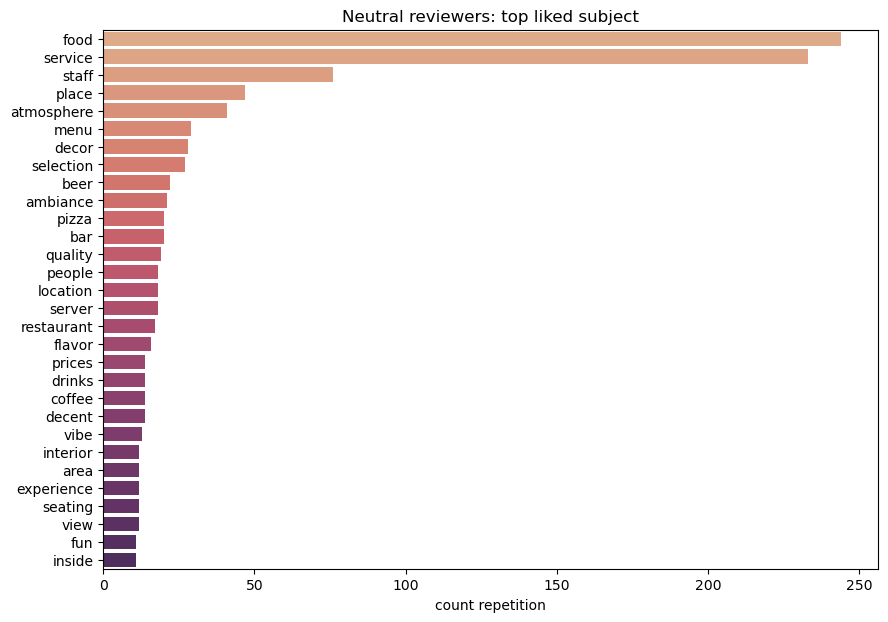

In [13]:
#Examine the top 30 words
top_words = 30

top_words_liked = dict(sorted(word_counts_liked.items(), key=itemgetter(1), reverse=True)[:top_words])
top_words_disliked = dict(sorted(word_counts_disliked.items(), key=itemgetter(1), reverse=True)[:top_words])

words = [key for key, number in top_words_liked.items()]
count = [number for key, number in top_words_liked.items()]

fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x=count, y=words, palette='flare')
ax.set_xlabel('count repetition')
ax.set_title('Neutral reviewers: top liked subject')

Text(0.5, 1.0, 'Neutral reviewers: top disliked subject')

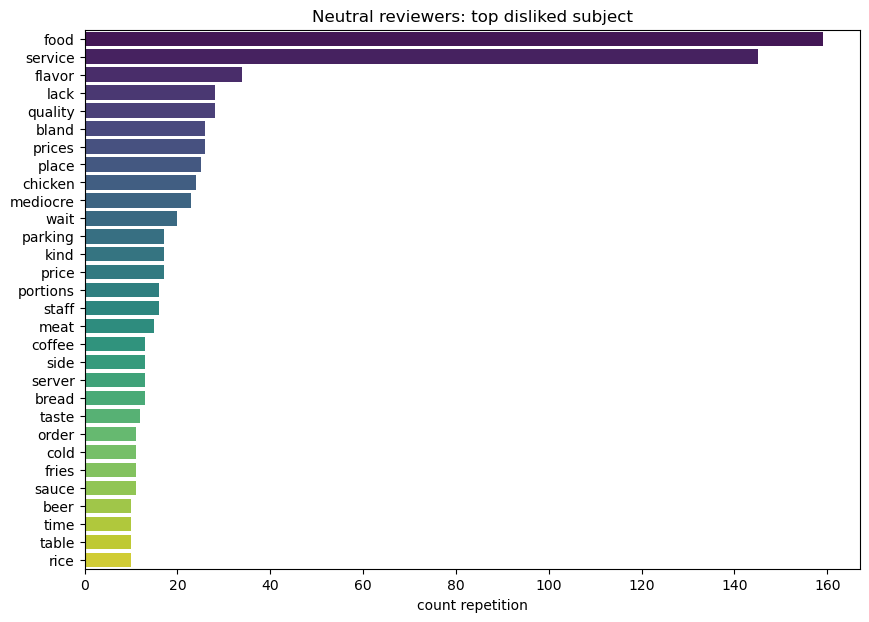

In [14]:
words = [key for key, number in top_words_disliked.items()]
count = [number for key, number in top_words_disliked.items()]

fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x=count, y=words, palette='viridis')
ax.set_xlabel('count repetition')
ax.set_title('Neutral reviewers: top disliked subject')

### Extract sentiments from QA's with k-means unsupervised clustering

By grouping/clustering review summaries, we can attempt to find more generic sentiments about the neutral reviewer's likes & dislikes and compare it with the direct word count above.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Vectorize the short like/dislikes
vectorizer = TfidfVectorizer(max_df=0.99, #filter useless terms that appear in more than max_df fraction of texts 
                             min_df=0, #ignore terms that do not appear in at least min_df texts
                             lowercase=True,
                             stop_words='english')

#Latent semantic analysis - information retrieval and text mining pipeline
    #Reduce the dimensionality of Tfidf vectors and normalize
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))

def fit_invert_kmeans(X, n_clusters=5, seed=0):
    '''
    Fit input text X with unsupervised kmeans. 
    Then invert the vectorizer to find the key words in each centroid.
    
    X = text
    n_clusters = number of clusters passed to KMeans
    seed = random seed state for centroid initialization in KMeans
    '''
    #Fit the kmeans to X
    kmeans = KMeans(n_clusters=n_clusters, #number of centroids
                    max_iter=1000, #max iterations for a single run
                    n_init=1, #number of times kmeans runs with different centroids
                    random_state=seed #centroid initialization
                   ).fit(X)

    cluster_ID, cluster_size = np.unique(kmeans.labels_, return_counts=True)
    
    #Invert kmeans to identify cluster centers (most important words per cluster)
    centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    centroids_sorted = centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    key_words={}
    for i in range(n_clusters):
        keys=[]
        for j in centroids_sorted[i, :2]: #return the top 2 words from each cluster
            keys.append(terms[j])
            key_words[i] = keys
    
    return cluster_ID, cluster_size, key_words

#First lets see how many clusters we will likely need using the kmeans elbow method
def elbow_method(X, seed=0):
    '''
    Get the optimal number of clusters in order to feed to the kmeans clustering algorithm.
    '''
    n_clusters = range(1, 100)
    kmeans = [KMeans(n_clusters=i, max_iter=1000, n_init=1, random_state=seed) for i in n_clusters]

    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))] #score per cluster.
    score = [i*-1 for i in score] #convert to positive scores.
    
    plt.plot(n_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    plt.show()


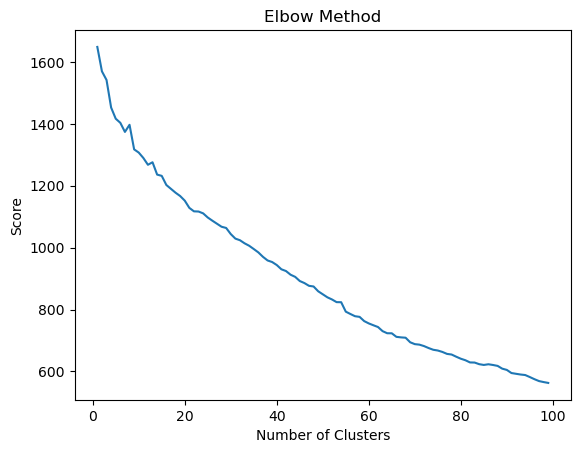

In [34]:
#Starting with the liked attributes:
X_neut_liked = lsa.fit_transform(vectorizer.fit_transform(neut_like_dis['liked']))      
    
elbow_method(X_neut_liked)

In [35]:
#This doesnt follow a clean elbow relation, so lets use a reasonable number of clusters ~20 where the descent
    #begins to shallow out a bit
fit_neut_liked = fit_invert_kmeans(X_neut_liked, n_clusters=20)

In [36]:
#Disliked attributes:
X_neut_dis = lsa.fit_transform(vectorizer.fit_transform(neut_like_dis['disliked']))   
fit_neut_disliked = fit_invert_kmeans(X_neut_dis, n_clusters=20)

In [37]:
#Gather the top 2 words from each of the 20 clusters

positive_words=[]
negative_words=[]

for i in fit_neut_liked[2]:
    centriod = fit_neut_liked[2][i]
    for j in centriod:
        positive_words.append(j)

for i in fit_neut_disliked[2]:
    centriod = fit_neut_disliked[2][i]
    for j in centriod:
        negative_words.append(j)

In [38]:
#Now we can see what the top words from each cluster is:

repeated_words=[]
print('top liked aspects per cluster:')
for i in positive_words:
    if i not in repeated_words:
        print(i, end=' ')
        
repeated_words=[]
print('\n\ntop disliked aspects per cluster:')
for i in negative_words:
    if i not in repeated_words:
        
        print(i, end=' ')

top liked aspects per cluster:
customer service great service okay just service good friendly staff clean nice area salads decent ok wasn small nice people food good cool pretty ambiance dry loud really fresh beautiful good pretty atmosphere nice place great attentive server decor nice 

top disliked aspects per cluster:
fell short service bad disorganized time little pieces mediocre food isn impressive wasn cold lacking flavor slow service just food great food didn just loud noise long lines bit soggy food average place just don think greasy fries portions small 

So while we can't order these in importance as easily, we are able to catch some more general sentiments with this unsupervised ML method that wasn't available in our direct word count above.

### What have we learned?
- food and service quality are of course the #1 predictor in how a reviewer will rate a restaurant
Ignoring food/service and looking at the finer details:
- food flavor, quality, & price are common complaints among neutral reviewers
    - i.e., a bad meal begins to ruin the overall experience
- the staff, atmosphere, ambiance, location, decor, and overall feeling of a place are commonly strong points of neutral reviewers
    - i.e., a place a reviewer is comfortable in is important, but not enough on its own to make the reviewer love the place

This, of course, is extremely generic. To get a better intuition for an individual business, we would take a closer look at this overall data prep, analysis, & extraction pipeline limited to one business.